In [ ]:
# http://combine-australia.github.io/RNAseq-R/06-rnaseq-day1.html

In [57]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install("gplots")
# biocLite("limma")
# install.packages('data.table')


Installing package into 'C:/Users/Pete/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'data.table' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Pete\AppData\Local\Temp\RtmpoNI6HK\downloaded_packages


In [2]:
version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          3                           
minor          6.3                         
year           2020                        
month          02                          
day            29                          
svn rev        77875                       
language       R                           
version.string R version 3.6.3 (2020-02-29)
nickname       Holding the Windsock        

In [3]:
library(limma)
library(reshape2)
library(Glimma)
library(ggplot2)
library(ggrepel)
# library(reshape)
library(edgeR)
library(gplots)
library(amap)
library(ggfortify)
library(data.table)
# library(Mus.musculus)


Attaching package: 'gplots'


The following object is masked from 'package:stats':

    lowess



Attaching package: 'data.table'


The following objects are masked from 'package:reshape2':

    dcast, melt




In [4]:

# change this
setwd("C:\\Users\\Pete\\DSC180B-PROJECT")

In [5]:
file_url = 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE44639&format=file'            
raw_dir = "data/raw/"
temp_dir = "data/temp/"
file_name = 'GSE44639_RAW.tar'

In [6]:
ingest_data <- function(file_url, file_name, raw_dir, temp_dir) {
    if (!dir.exists(raw_dir)) {
        dir.create(raw_dir, recursive = TRUE)
    }
    out = paste(raw_dir, file_name, sep="")
    utils::download.file(file_url, destfile=out, mode="wb")
    utils::untar(out, exdir=temp_dir)
}

ingest_data(file_url, file_name, raw_dir, temp_dir)

In [7]:
read_all_files_in_dir_with_columns <- function(file_dir, required_columns) {
    files <- list.files(path=file_dir)
    
    all <- list()
    
    for (i in files) {
        fp <- paste(file_dir, i, sep='')
        seqdata <- read.delim(gzfile(fp), stringsAsFactors = FALSE)
        columns <- colnames(seqdata)
        
        has_unidentified_col <- FALSE
        
        # ignore samples with columns not present in required_columns
        for (c in columns) {
            if (!any(required_columns==c)) {
                has_unidentified_col <- TRUE
                break
            }
        }
        
        if (has_unidentified_col) {
            next
        }
        
        sampleName = strsplit(fp, "/")[[1]][3]
        sampleName = strsplit(sampleName, ".txt")[[1]][1]
        
        
        cellType = strsplit(fp, "_")[1]
        cellType = cellType[[1]][3]
        cellType = strsplit(cellType, ".txt")
        cellType = cellType[[1]][1]
        
        healthy <- !grepl("P", fp, fixed=TRUE)
        
        # add healthy column
        seqdata$healthy <- healthy
        seqdata$cellType <- cellType
        seqdata$sampleName <- sampleName
        
        if (length(all) == 0) {
            all <- seqdata
        } else {
            all <- rbind(all, seqdata)
        }
    }
    
    return(all)
}

required_columns <- list("miRNA", "Chromosome", "Position", "Strand", "Total.miRNA.reads", "RPM..reads.per.million.")
all <- read_all_files_in_dir_with_columns(temp_dir, required_columns)

In [6]:
unique(all['cellType'])

,cellType
,<chr>
1,Naive
2517,rTreg
5121,aTreg
8704,Tcm
10193,Tem
11615,Ttm


# TEST USING MANUALLY CALCULATED RPM


In [ ]:
countmatrix <- dcast(all, miRNA ~ sampleName, value.var= "Total.miRNA.reads", fill= 0)
rownames(countmatrix) <- countmatrix$miRNA
countmatrix$miRNA <- NULL

testcpm <- cpm(countmatrix)
testcpm

In [ ]:
countmatrix

In [ ]:
table(rowSums(thresh))

In [ ]:
# Which values in myCPM are greater than 0.5?
thresh <- testcpm > 100
# This produces a logical matrix with TRUEs and FALSEs
head(thresh)
# we would like to keep genes that have at least 5 TRUES in each row of thresh
keep <- rowSums(thresh) >= 9
# Subset the rows of countdata to keep the more highly expressed genes
counts.keep <- countdata[keep,]
summary(keep)

In [ ]:
dim(counts.keep)


In [ ]:
y <- DGEList(counts.keep)
# Apply normalisation to DGEList object
y <- calcNormFactors(y)
y

In [ ]:
sampleinfo <- all[row.names(unique(all[,c("sampleName", "cellType", "healthy")])),][,c("sampleName", "healthy", "cellType")]
row.names(sampleinfo) <- NULL

data.frame(sampleinfo$CellType)
head(sampleinfo)

In [ ]:
labels <- paste(sampleinfo$sampleName, sampleinfo$cellType, sampleinfo$healthy)
group <- paste(sampleinfo$cellType,sampleinfo$healthy,sep=".")
group <- factor(group)
glMDSPlot(y, labels=labels, groups=group, folder="mds")

In [ ]:
# our groups
group

In [ ]:
# Specify a design matrix without an intercept term
design <- model.matrix(~ 0 + group)

In [ ]:
colnames(design) <- levels(group)

In [ ]:
par(mfrow=c(1,1))
v <- voom(y,design,plot = TRUE)

In [ ]:
y

In [ ]:
fit <- lmFit(v)
names(fit)

In [ ]:
# we want to compare healthy naive cells to pre-t1 naive cells
cont.matrix <- makeContrasts(B.healthVsdiab=Naive.TRUE - Naive.FALSE,levels=design)
cont.matrix

In [ ]:
fit.cont <- contrasts.fit(fit, cont.matrix)
fit.cont <- eBayes(fit.cont)
dim(fit.cont)


In [ ]:
summa.fit <- decideTests(fit.cont)
summary(summa.fit)

# END TEST

In [7]:
# HISTOGRAM OF ALL DATASET, NOT JUST NAIVE HERE

countdata <- dcast(all, miRNA ~ sampleName, value.var= "Total.miRNA.reads", fill= 0)
rownames(countdata) <- countdata$miRNA
countdata$miRNA <- NULL

group<-factor(c(rep("pret1Naive",6),rep("pret1rTreg",8),rep("pret1aTreg",9),rep("pret1Tcm",5),
               rep("pret1Ttm",5),rep("pret1rTem",5),rep("healthyNaive",7),rep("healthyrTreg",7),
               rep("healthyaTreg",6),rep("healthyTcm",7),rep("healthyTem",7),rep("healthyTtm",7)))

countdata <- countdata + 0.5

d <- DGEList(counts=countdata,group=group)

# #filter, need counts over 1 in 6 samples
# keep <- rowSums(cpm(d)>1) >= 6
# d <- d[keep,]
dim (d)

# d$samples
# filter all mirna with less than 1.5*(# of total samples) of counts across all samples. lowly expressing gene
dd <- d[rowSums(d$counts) >= 1.5*ncol(d), ]
# multiply by million and divide by column library size to get RPM
d<-1e+06 * dd$count/expandAsMatrix(d$samples$lib.size,dim(dd))
# take the log RPM
d<-log2(d)
d

Warning message in dcast(all, miRNA ~ sampleName, value.var = "Total.miRNA.reads", :
"The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(all). In the next version, this warning will become an error."


[1] 1693   79

,GSM1088200_M7_Naive,GSM1088201_M8_Naive,GSM1088202_M9_Naive,GSM1088203_M10_Naive,GSM1088204_M12_Naive,GSM1088205_M29_Naive,GSM1088206_M7_rTreg,GSM1088207_M8_rTreg,GSM1088208_M9_rTreg,GSM1088209_M10_rTreg,...,GSM1088270_P5_Tem,GSM1088271_P6_Tem,GSM1088272_P7_Tem,GSM1088273_P1_Ttm,GSM1088274_P2_Ttm,GSM1088275_P3_Ttm,GSM1088276_P4_Ttm,GSM1088277_P5_Ttm,GSM1088278_P6_Ttm,GSM1088279_P7_Ttm
hsa-let-7a,15.601431,14.667918,15.931762,15.345674,15.737569,16.7248120,14.662525,15.519505,14.599880,15.926746,...,15.304624,16.065307,15.752622,13.858913,16.149960,15.810463,15.539709,15.6540257,15.671697,15.630897
hsa-let-7a-1,10.959754,8.627902,9.849978,10.852441,10.494944,10.1990432,7.522973,12.655194,8.946438,9.670511,...,9.640929,13.259520,9.786825,7.595817,9.153334,9.956967,9.112977,8.7341197,9.059052,9.861231
hsa-let-7a-2,11.013193,10.006414,10.165284,9.620815,10.737283,10.2595460,7.522973,10.079882,9.683404,9.899416,...,8.747845,9.939419,9.905654,7.968860,9.314697,10.309735,9.412896,9.0535916,9.163075,9.991969
hsa-let-7a-3,10.786422,8.627902,9.805240,9.334907,10.446557,10.1786705,7.522973,10.079882,8.946438,9.630801,...,8.747845,9.518281,9.733061,7.497969,9.128162,9.883177,9.030177,8.6914228,9.059052,9.831817
hsa-let-7a*,5.231833,6.305974,2.816555,3.145082,4.283326,4.3549630,7.522973,5.436026,7.361476,1.882608,...,5.940490,3.635638,4.808737,5.913007,4.118104,1.461112,2.726396,6.4839993,2.317585,1.493452
hsa-let-7b,14.117530,14.864395,14.174657,12.153511,14.278151,14.8376991,15.022819,12.330844,13.701326,15.442583,...,12.540403,13.806815,14.325295,12.322398,15.131468,13.990299,13.452330,13.7198614,14.794078,13.728569
hsa-let-7b*,5.231833,6.305974,2.816555,3.145082,4.283326,0.3667723,7.522973,5.436026,7.361476,1.882608,...,5.940490,3.635638,4.127267,3.987007,2.695871,1.461112,1.141433,2.2192961,3.902547,2.715845
hsa-let-7c,10.589385,9.765405,11.204573,10.439703,9.824208,10.1553133,12.732427,10.862291,13.089396,9.519233,...,7.525452,8.764921,8.865933,7.731169,8.716462,9.337629,9.538038,8.6622396,10.118485,9.024834
hsa-let-7d,11.674777,12.087334,12.622299,13.001507,12.871208,13.0178922,9.107936,14.363804,11.448939,12.536349,...,11.366754,13.831626,12.698340,11.033586,12.768674,12.908712,12.418139,12.6259735,12.855774,12.994792
hsa-let-7d*,5.231833,6.305974,6.275987,4.730044,6.322855,3.1378311,7.522973,5.436026,8.946438,4.204536,...,5.940490,5.220601,6.312236,7.219668,2.806902,4.920544,4.311358,5.3531518,6.018025,5.791133


In [8]:
# DIFFERENT FILTER

# countdata <- dcast(all, miRNA ~ sampleName, value.var= "Total.miRNA.reads", fill= 0)
# rownames(countdata) <- countdata$miRNA
# countdata$miRNA <- NULL

# group<-factor(c(rep("pret1Naive",6),rep("pret1rTreg",8),rep("pret1aTreg",9),rep("pret1Tcm",5),
#                rep("pret1Ttm",5),rep("pret1rTem",5),rep("healthyNaive",7),rep("healthyrTreg",7),
#                rep("healthyaTreg",6),rep("healthyTcm",7),rep("healthyTem",7),rep("healthyTtm",7)))

# countdata <- countdata + 0.5

# d <- DGEList(counts=countdata,group=group)

# # #filter, need counts over 1 in 6 samples
# # keep <- rowSums(cpm(d)>1) >= 6
# # d <- d[keep,]
# dim (d)


# # Which values in myCPM are greater than 0.5?
# thresh <- d$counts >= 1
# # This produces a logical matrix with TRUEs and FALSEs
# # head(thresh)
# # we would like to keep genes that have at least 5 TRUES in each row of thresh
# keep <- rowSums(thresh) >= 5
# # Subset the rows of countdata to keep the more highly expressed genes
# dd <- countdata[keep,]

# d<-1e+06 * dd/expandAsMatrix(d$samples$lib.size,dim(dd))
# # take the log RPM
# d<-log2(d)
# d <- as.matrix(d)

In [9]:
colnames(d)<-sub("^[^_]*_", "", colnames(d))
colnames(d)<-sub("^[^_]*M", "Healthy", colnames(d))
colnames(d)<-sub("^[^_]*P", "PreD", colnames(d))

colnames(d)

[1] "Healthy7_Naive"  "Healthy8_Naive"  "Healthy9_Naive"  "Healthy10_Naive"
 [5] "Healthy12_Naive" "Healthy29_Naive" "Healthy7_rTreg"  "Healthy8_rTreg" 
 [9] "Healthy9_rTreg"  "Healthy10_rTreg" "Healthy12_rTreg" "Healthy26_rTreg"
[13] "Healthy27_rTreg" "Healthy30_rTreg" "Healthy7_aTreg"  "Healthy8_aTreg" 
[17] "Healthy9_aTreg"  "Healthy10_aTreg" "Healthy12_aTreg" "Healthy26_aTreg"
[21] "Healthy27_aTreg" "Healthy29_aTreg" "Healthy30_aTreg" "Healthy7_Tcm"   
[25] "Healthy8_Tcm"    "Healthy9_Tcm"    "Healthy10_Tcm"   "Healthy12_Tcm"  
[29] "Healthy7_Tem"    "Healthy8_Tem"    "Healthy9_Tem"    "Healthy10_Tem"  
[33] "Healthy12_Tem"   "Healthy7_Ttm"    "Healthy8_Ttm"    "Healthy9_Ttm"   
[37] "Healthy10_Ttm"   "Healthy12_Ttm"   "PreD1_Naive"     "PreD2_Naive"    
[41] "PreD3_Naive"     "PreD4_Naive"     "PreD5_Naive"     "PreD6_Naive"    
[45] "PreD7_Naive"     "PreD1_rTreg"     "PreD2_rTreg"     "PreD3_rTreg"    
[49] "PreD4_rTreg"     "PreD5_rTreg"     "PreD6_rTreg"     "PreD7_rTreg"    
[53] "PreD1_aTreg"     "PreD3_aTreg"     "PreD4_aTreg"     "PreD5_aTreg"    
[57] "PreD6_aTreg"     "PreD7_aTreg"     "PreD1_Tcm"       "PreD2_Tcm"      
[61] "PreD3_Tcm"       "PreD4_Tcm"       "PreD5_Tcm"       "PreD6_Tcm"      
[65] "PreD7_Tcm"       "PreD1_Tem"       "PreD2_Tem"       "PreD3_Tem"      
[69] "PreD4_Tem"       "PreD5_Tem"       "PreD6_Tem"       "PreD7_Tem"      
[73] "PreD1_Ttm"       "PreD2_Ttm"       "PreD3_Ttm"       "PreD4_Ttm"      
[77] "PreD5_Ttm"       "PreD6_Ttm"       "PreD7_Ttm"

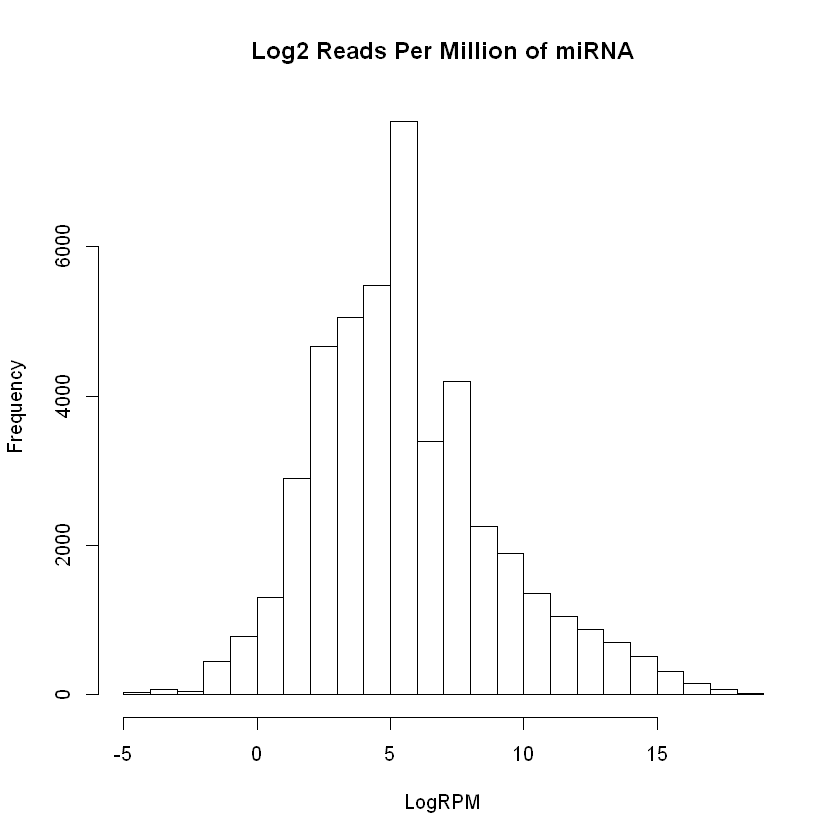

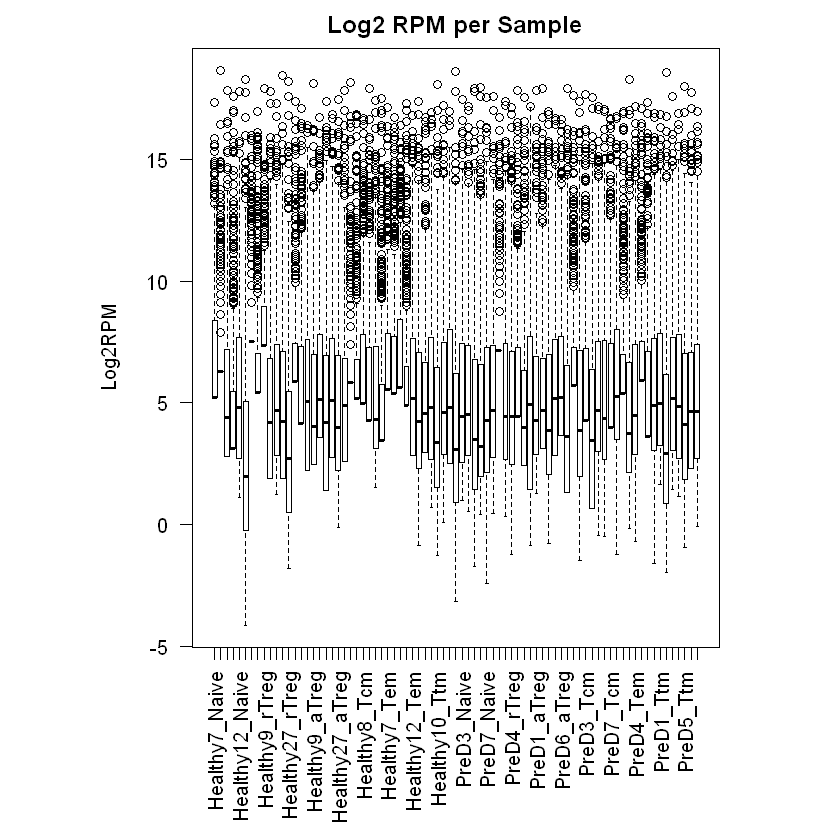

In [10]:
hist(d, main="Log2 Reads Per Million of miRNA", xlab="LogRPM")
par(mar=c(8,8,2,5))
boxplot(x=d,las=2,main="Log2 RPM per Sample", ylab="Log2RPM")

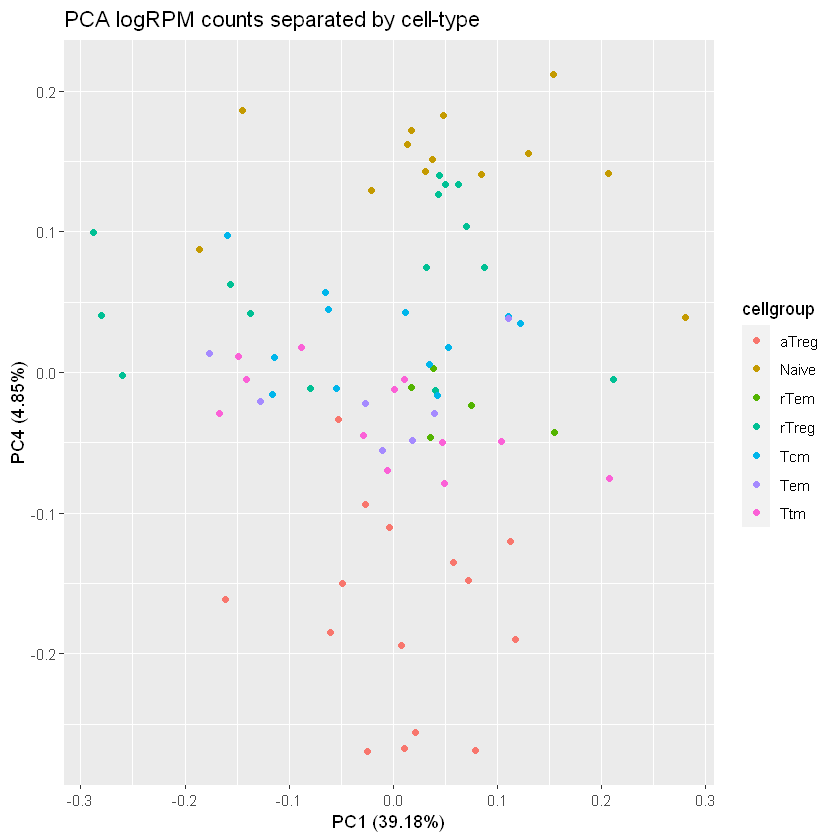

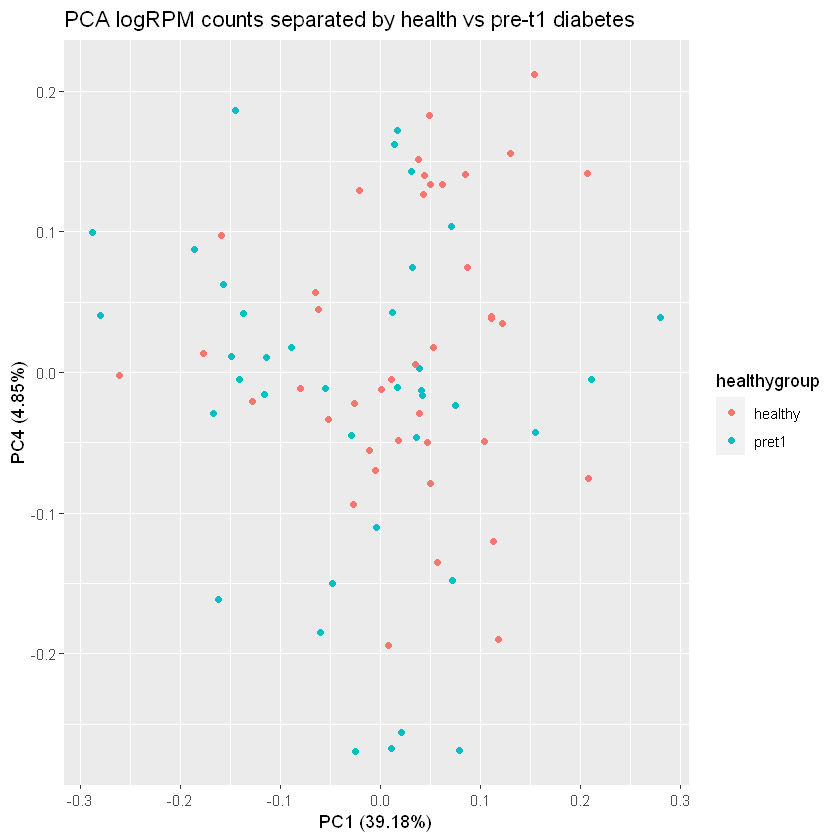

In [11]:
healthygroup<-factor(c(rep("pret1",38),rep("healthy",41)))
cellgroup<-factor(c(rep("Naive",6),rep("rTreg",8),rep("aTreg",9),rep("Tcm",5),
               rep("Ttm",5),rep("rTem",5),rep("Naive",7),rep("rTreg",7),
               rep("aTreg",6),rep("Tcm",7),rep("Tem",7),rep("Ttm",7)))


# healthygroup

transpose_d<- as.data.frame(t(d))
transpose_d<- cbind(transpose_d, healthygroup)
transpose_d<- cbind(transpose_d, cellgroup)


pca_res <- prcomp(transpose_d[1:572], scale. = TRUE)

axis1 <- 1
axis2 <- 4
# comparing cell vs health
autoplot(pca_res, data=transpose_d, x=axis1,y=axis2,colour='cellgroup',main='PCA logRPM counts separated by cell-type')
autoplot(pca_res, data=transpose_d, x=axis1,y=axis2,colour='healthygroup',main='PCA logRPM counts separated by health vs pre-t1 diabetes')

# autoplot(kmeans(transpose_d[1:572], 12), data=transpose_d)

In [12]:
# group


# cellgroup
head(transpose_d)

,hsa-let-7a,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7a*,hsa-let-7b,hsa-let-7b*,hsa-let-7c,hsa-let-7d,hsa-let-7d*,...,hsa-miR-95,hsa-miR-96,hsa-mir-98,hsa-miR-98,hsa-miR-99a,hsa-mir-99b,hsa-miR-99b,hsa-miR-99b*,healthygroup,cellgroup
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
Healthy7_Naive,15.60143,10.959754,11.013193,10.786422,5.231833,14.11753,5.2318335,10.589385,11.67478,5.231833,...,5.231833,6.816796,6.816796,8.401758,8.039188,5.23183346,5.231833,5.231833,pret1,Naive
Healthy8_Naive,14.66792,8.627902,10.006414,8.627902,6.305974,14.86439,6.3059739,9.765405,12.08733,6.305974,...,6.305974,6.305974,6.305974,7.890936,7.890936,6.30597387,6.305974,6.305974,pret1,Naive
Healthy9_Naive,15.93176,9.849978,10.165284,9.805240,2.816555,14.17466,2.8165554,11.204573,12.62230,6.275987,...,6.904018,2.816555,4.401518,9.083342,6.275987,2.81655541,6.275987,2.816555,pret1,Naive
Healthy10_Naive,15.34567,10.852441,9.620815,9.334907,3.145082,12.15351,3.1450820,10.439703,13.00151,4.730044,...,4.730044,3.145082,4.730044,7.232545,9.167450,3.14508196,4.730044,3.145082,pret1,Naive
Healthy12_Naive,15.73757,10.494944,10.737283,10.446557,4.283326,14.27815,4.2833265,9.824208,12.87121,6.322855,...,6.157796,1.113401,1.113401,8.102086,6.242684,1.11340147,6.470953,4.572833,pret1,Naive
Healthy29_Naive,16.72481,10.199043,10.259546,10.178670,4.354963,14.83770,0.3667723,10.155313,13.01789,3.137831,...,4.196357,-4.156790,2.351005,7.976674,4.990415,-0.06932684,5.102954,3.156093,pret1,Naive


# NAIVE

ERROR: Error in library(data.table): there is no package called 'data.table'


In [8]:
#subset the naive cells from all
pret1 <- all[all$healthy == FALSE,] 
# naive <- all[all$cellType == 'Naive',] 
naive <- all[all$cellType == 'rTreg',] 

In [9]:
countdata <- dcast(naive, miRNA ~ sampleName, value.var= "Total.miRNA.reads", fill= 0)

rownames(countdata) <- countdata$miRNA
countdata$miRNA <- NULL
countdata

Warning message in dcast(naive, miRNA ~ sampleName, value.var = "Total.miRNA.reads", :
"The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(naive). In the next version, this warning will become an error."


,GSM1088206_M7_rTreg,GSM1088207_M8_rTreg,GSM1088208_M9_rTreg,GSM1088209_M10_rTreg,GSM1088210_M12_rTreg,GSM1088211_M26_rTreg,GSM1088212_M27_rTreg,GSM1088213_M30_rTreg,GSM1088245_P1_rTreg,GSM1088246_P2_rTreg,GSM1088247_P3_rTreg,GSM1088248_P4_rTreg,GSM1088249_P5_rTreg,GSM1088250_P6_rTreg,GSM1088251_P7_rTreg
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hsa-let-7a,70,542,75,8446,8581,3862,84383,867,17268,52,13644,42564,697,6588,35750
hsa-let-7a-1,0,74,1,110,167,74,592,17,204,1,170,716,16,548,253
hsa-let-7a-2,0,12,2,129,207,79,631,17,230,3,189,819,17,155,286
hsa-let-7a-3,0,12,1,107,156,74,579,16,195,1,165,703,16,128,243
hsa-let-7a*,0,0,0,0,2,3,8,0,19,0,4,27,0,0,0
hsa-let-7b,90,59,40,6038,2654,645,17362,139,4098,11,4623,8913,98,890,9205
hsa-let-7b*,0,0,0,0,6,4,14,0,0,0,5,8,0,0,77
hsa-let-7c,18,21,26,99,58,37,881,11,144,1,128,537,10,60,262
hsa-let-7d,1,243,8,805,1019,596,5576,51,1420,12,1897,5033,99,1563,5386


In [10]:
# group<-factor(c(rep("pret1Naive",6),rep("healthyNaive",7))) # naive
group<-factor(c(rep("healthyrTreg",8),rep("pret1rTreg",7))) # rtreg
group

# # create model
# design2<-model.matrix(~0+group)
# design1<-model.matrix(~group)
# design<-cbind(design1[,1],design1[,3],design2[,1],design1[,4:6])
# # colnames(design)<-c("(Intercept)","grouprTreg","groupaTreg","groupTcm","groupTem","groupTtm")
# design


[1] healthyrTreg healthyrTreg healthyrTreg healthyrTreg healthyrTreg
 [6] healthyrTreg healthyrTreg healthyrTreg pret1rTreg   pret1rTreg  
[11] pret1rTreg   pret1rTreg   pret1rTreg   pret1rTreg   pret1rTreg  
Levels: healthyrTreg pret1rTreg

In [11]:
# design1[,2]

In [12]:
# add 0.5 to counts to prevent log(0) = -inf
countdata <- countdata + 0.5

d <- DGEList(counts=countdata,group=group)

# #filter, need counts over 1 in 6 samples
# keep <- rowSums(cpm(d)>1) >= 6
# d <- d[keep,]
dim (d)

d$samples
# filter all mirna with less than 1.5*(# of total samples) of counts across all samples. lowly expressing gene
dd <- d[rowSums(d$counts) >= 1.5*ncol(d), ]
# multiply by million and divide by column library size to get RPM
d<-1e+06 * dd$count/expandAsMatrix(d$samples$lib.size,dim(dd))
# take the log RPM
d<-log2(d)
d

[1] 1082   15

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
GSM1088206_M7_rTreg,healthyrTreg,2413,1
GSM1088207_M8_rTreg,healthyrTreg,11244,1
GSM1088208_M9_rTreg,healthyrTreg,2735,1
GSM1088209_M10_rTreg,healthyrTreg,135291,1
GSM1088210_M12_rTreg,healthyrTreg,211397,1
GSM1088211_M26_rTreg,healthyrTreg,133554,1
GSM1088212_M27_rTreg,healthyrTreg,1757554,1
GSM1088213_M30_rTreg,healthyrTreg,8303,1
GSM1088245_P1_rTreg,pret1rTreg,366076,1


,GSM1088206_M7_rTreg,GSM1088207_M8_rTreg,GSM1088208_M9_rTreg,GSM1088209_M10_rTreg,GSM1088210_M12_rTreg,GSM1088211_M26_rTreg,GSM1088212_M27_rTreg,GSM1088213_M30_rTreg,GSM1088245_P1_rTreg,GSM1088246_P2_rTreg,GSM1088247_P3_rTreg,GSM1088248_P4_rTreg,GSM1088249_P5_rTreg,GSM1088250_P6_rTreg,GSM1088251_P7_rTreg
hsa-let-7a,14.834508,15.558180,14.752648,15.930000,15.308987,14.819824,15.551104,16.672872,15.5256401,14.011911,15.0891062,15.165132,14.917354,16.112655,15.2643635
hsa-let-7a-1,7.694956,12.693869,9.099206,9.673765,9.629990,9.123673,8.397102,11.041435,9.1257419,8.882628,8.7667022,9.272592,9.515699,12.526268,8.1245297
hsa-let-7a-2,7.694956,10.118557,9.836172,9.902671,9.938941,9.217388,8.489070,11.041435,9.2984078,10.105020,8.9191283,9.466369,9.600588,10.707691,8.3010791
hsa-let-7a-3,7.694956,10.118557,9.099206,9.634055,9.531992,9.123673,8.365096,10.956546,9.0608097,8.882628,8.7237617,9.246176,9.515699,10.432545,8.0664657
hsa-let-7a*,7.694956,5.474701,7.514243,1.885862,3.563901,4.711860,2.273894,5.912152,5.7351871,7.297665,3.5229993,4.569129,4.471305,2.426920,-0.8613123
hsa-let-7b,15.194802,12.369519,13.854093,15.445837,13.616198,12.238778,13.270118,14.036273,13.4506652,11.821227,13.5278439,12.909546,12.093356,13.225392,13.3069681
hsa-let-7b*,7.694956,5.474701,7.514243,1.885862,4.942413,5.074430,3.044412,5.912152,0.4497849,7.297665,3.8125059,2.875232,4.471305,2.426920,6.4148121
hsa-let-7c,12.904410,10.900966,13.242164,9.522487,8.112338,8.133324,8.970248,10.435714,8.6247106,8.882628,8.3586988,8.857890,8.863622,9.345783,8.1748614
hsa-let-7d,9.279919,14.402479,11.601706,12.539603,12.235619,12.124883,11.631575,12.598652,11.9219680,11.941521,12.2429584,12.085116,12.107929,14.037484,12.5338202
hsa-let-7d*,7.694956,5.474701,9.099206,4.207790,5.885829,6.152432,3.914351,5.912152,6.0644947,7.297665,6.0254996,5.582185,4.471305,5.234275,7.7861462


In [18]:
# CALCULATE ABS-F FUNCTION
F<-data.frame(nrow(d))
# NAIVE
x<-data.frame(nrow(d),2) # for calculating fold change later
# for (i in 1:nrow(d)) {
# a<-6*abs(mean(d[i,1:6])-mean(d[i,1:13]))+7*abs(mean(d[i,7:13])-mean(d[i,1:13]))
# bb = 0
#     for (j in 1:6) {
#         b<-abs(d[i,j]-mean(d[i,1:6]))
#         bb = bb +b
#     }

#     for (j in 7:13) {
#         b<-abs(d[i,j]-mean(d[i,7:13]))
#         bb = bb +b
#     }

#     F[i]<-12*a/bb


#     # X contains the mean of the logRPM of each group.
#     x[i,2]<-mean(d[i,1:6])
#     x[i,1]<-mean(d[i,7:13])

# }

#rtreg
for (i in 1:nrow(d)) {
a<-8*abs(mean(d[i,1:8])-mean(d[i,1:15]))+7*abs(mean(d[i,9:15])-mean(d[i,1:15]))
bb = 0
    for (j in 1:8) {
        b<-abs(d[i,j]-mean(d[i,1:8]))
        bb = bb +b
    }

    for (j in 9:15) {
        b<-abs(d[i,j]-mean(d[i,9:15]))
        bb = bb +b
    }

    F[i]<-12*a/bb


    # X contains the mean of the logRPM of each group.
    x[i,2]<-mean(d[i,1:8])
    x[i,1]<-mean(d[i,9:15])

}

names(F)<-rownames(d)
rownames(x)<-rownames(d)
absFOver9.6<-length(F[,F>9.6]) # 9.6 chosen from paper. corresponds to less than 1% false discovery rate in limma package
absFOver9.6

[1] 3

hsa-miR-140-3p    hsa-miR-15a hsa-miR-331-3p 
      1.020527       2.145081      -3.278018

Warning message:
"Removed 499 rows containing missing values (geom_text_repel)."


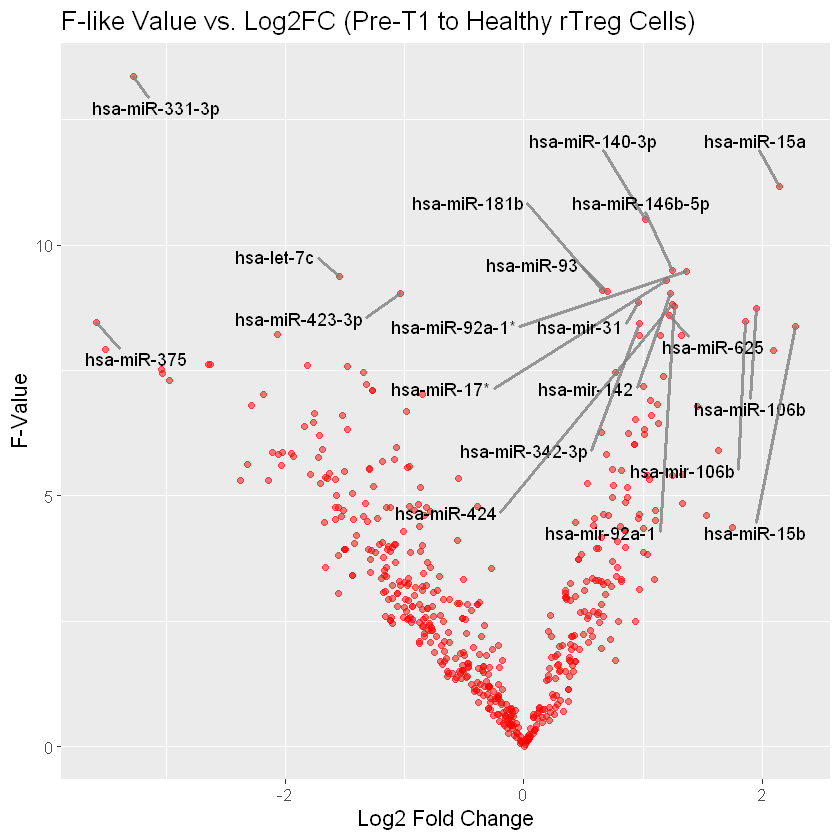

In [20]:
# f contains the fold change, F contains the abs-F value

# f <- x[names(-sort(-F))[1:166],1]-x[names(-sort(-F))[1:166],2]

f <- x[names(-sort(-F))[1:absFOver9.6],1]-x[names(-sort(-F))[1:absFOver9.6],2] # fold change on the mirna with ABS F>9.6

names(f)<-names(-sort(-F))[1:absFOver9.6]
# -sort(-f)

# filter by abs(logFC) >= 1
id<-c(names(f[f>=1]),names(f[-f>=1]))
# length(id)

# calculate logFC again for mirna which meet filters, might be redundant
y<-d[id,]
de<-rownames(x)%in%id
f<-c(x[de,1]-x[de,2])

saved_mirna<- rownames(x[de,])
names(f)<- saved_mirna
f # gives us the filtered names of mirna with absF > 9.6 with abs(logFC) >=1.


fval<-as.numeric(F)
fold<-as.numeric(x[,1]-x[,2])

volcanodf<-data.frame(fold,fval)


## 20 highest F-values labeled
numToLabel = 20

ggplot(volcanodf, aes(fold,fval)) +
    geom_point(color='red',alpha = 0.5) + 
    geom_text_repel(aes(fold,fval),segment.size = 1, min.segment.length=0.5, box.padding=1,
    segment.alpha = .8,
    force = 1,segment.color = "grey50",label=as.character(ifelse(F >= as.numeric(-sort(-F)[numToLabel]), colnames(F), NA)),hjust=0,vjust=0) +
    labs(y= "F-Value", x = "Log2 Fold Change") +
    ggtitle("F-like Value vs. Log2FC (Pre-T1 to Healthy rTreg Cells)") + theme(text = element_text(size = 13))   




# plot(fold,fval,main="F-like Stat vs. Log2FC (Pre-T1 to Healthy Naive Cells)",xlab="Log2 Fold change",ylab="F value",pch=20,col="blue")
# # abline(h=c(2,-2),v=10,col="red")

# # get top 10
# f10<- as.numeric(-sort(-F)[1:10])
# F10<- as.numeric(f[1:10])

# #only puts labels if the F-value is greater than absF 9.6
# # text(fold,fval,labels=as.character(ifelse(F >= 9.6, colnames(F), NA)),cex=0.87)

# ## 20 highest F-values labeled
# numToLabel = 20
# text(fold,fval,labels=as.character(ifelse(F >= as.numeric(-sort(-F)[numToLabel]), colnames(F), NA)),cex=0.87) # cex is fontsize
# # text(f10,F10,labels=colnames(-sort(-F)[1:10]),cex=0.8)

In [411]:
# c(names(f[f>=2]),names(f[-f>=2]))
# id<-c(names(f[f>=2]),names(f[-f>=2]))
# length(id)

# #contains only counts of selected mirna
# y<-d[id,]
# -sort(-f)

f <- x[names(-sort(-F))[1:absFOver9.6],1]-x[names(-sort(-F))[1:absFOver9.6],2] # fold change on the mirna with ABS F>9.6

names(f)<-names(-sort(-F))[1:absFOver9.6]
-sort(-f)
id<-c(names(f[f>=1]),names(f[-f>=1]))
length(id)

#contains only counts of selected mirna
y<-d[id,]
de<-rownames(x)%in%id
f<-c(x[de,1]-x[de,2])

saved_mirna<- rownames(x[de,])

names(f)<- saved_mirna
f

hsa-miR-374a    hsa-miR-181a*      hsa-miR-10a    hsa-mir-101-1 
       2.0030083        1.6218987        1.5830536        1.5443031 
   hsa-mir-101-2   hsa-miR-423-3p      hsa-miR-155   hsa-mir-320c-2 
       1.4936118        1.3329436        0.7017028       -1.4217113 
      hsa-mir-32     hsa-miR-99b*     hsa-miR-126*   hsa-miR-188-5p 
      -1.5472726       -1.7124148       -1.7712175       -1.8732665 
    hsa-miR-222*     hsa-mir-3648 hsa-miR-219-1-3p    hsa-mir-194-2 
      -1.9627548       -2.0261510       -2.0472834       -2.0932651 
     hsa-miR-676     hsa-miR-33a*      hsa-mir-766     hsa-mir-125a 
      -2.1332018       -2.1353904       -2.2265369       -2.2353970 
   hsa-mir-1273f    hsa-miR-130b*  hsa-miR-3173-5p      hsa-mir-600 
      -2.2564588       -2.2608358       -2.2783464       -2.2880177 
     hsa-miR-877   hsa-miR-582-3p     hsa-miR-4536     hsa-miR-4454 
      -2.3099558       -2.3257549       -2.3609925       -2.4288484 
    hsa-mir-3141     hsa-miR-3141     hsa-miR-194*     hsa-miR-340* 
      -2.5451117       -2.5499908       -2.5624970       -2.6348010 
     hsa-mir-574     hsa-mir-1234  hsa-miR-4677-3p     hsa-mir-4458 
      -2.6574802       -2.6743419       -2.6875543       -2.6905941 
 hsa-miR-4665-5p   hsa-mir-1972-1   hsa-mir-1972-2     hsa-mir-1973 
      -2.7130564       -2.8855673       -2.8855673       -2.9216406 
    hsa-mir-1280     hsa-mir-4485      hsa-miR-429     hsa-mir-130b 
      -2.9228307       -2.9293725       -3.0456583       -3.0684744 
   hsa-mir-1260b      hsa-mir-455     hsa-miR-151b     hsa-miR-376c 
      -3.1194568       -3.1258887       -3.2871839       -3.3859507 
  hsa-miR-455-3p   hsa-miR-369-3p  hsa-miR-3591-3p      hsa-miR-122 
      -3.4694091       -3.6763123       -4.0937602       -4.1238556 
     hsa-miR-375 
      -5.2964856

[1] 52

hsa-mir-101-1    hsa-mir-101-2      hsa-miR-10a      hsa-miR-122 
        1.544303         1.493612         1.583054        -4.123856 
    hsa-mir-1234     hsa-mir-125a     hsa-miR-126*    hsa-mir-1260b 
       -2.674342        -2.235397        -1.771218        -3.119457 
   hsa-mir-1273f     hsa-mir-1280     hsa-mir-130b    hsa-miR-130b* 
       -2.256459        -2.922831        -3.068474        -2.260836 
    hsa-miR-151b    hsa-miR-181a*   hsa-miR-188-5p    hsa-mir-194-2 
       -3.287184         1.621899        -1.873267        -2.093265 
    hsa-miR-194*   hsa-mir-1972-1   hsa-mir-1972-2     hsa-mir-1973 
       -2.562497        -2.885567        -2.885567        -2.921641 
hsa-miR-219-1-3p     hsa-miR-222*     hsa-mir-3141     hsa-miR-3141 
       -2.047283        -1.962755        -2.545112        -2.549991 
 hsa-miR-3173-5p       hsa-mir-32   hsa-mir-320c-2     hsa-miR-33a* 
       -2.278346        -1.547273        -1.421711        -2.135390 
    hsa-miR-340*  hsa-miR-3591-3p     hsa-mir-3648   hsa-miR-369-3p 
       -2.634801        -4.093760        -2.026151        -3.676312 
    hsa-miR-374a      hsa-miR-375     hsa-miR-376c   hsa-miR-423-3p 
        2.003008        -5.296486        -3.385951         1.332944 
     hsa-miR-429     hsa-miR-4454     hsa-mir-4458     hsa-mir-4485 
       -3.045658        -2.428848        -2.690594        -2.929373 
    hsa-miR-4536      hsa-mir-455   hsa-miR-455-3p  hsa-miR-4665-5p 
       -2.360992        -3.125889        -3.469409        -2.713056 
 hsa-miR-4677-3p      hsa-mir-574   hsa-miR-582-3p      hsa-mir-600 
       -2.687554        -2.657480        -2.325755        -2.288018 
     hsa-miR-676      hsa-mir-766      hsa-miR-877     hsa-miR-99b* 
       -2.133202        -2.226537        -2.309956        -1.712415

# ATREG

In [436]:
#subset the pre-t1 group from all
pret1 <- all[all$healthy == FALSE,] 
atreg <- all[all$cellType == 'aTreg',] 

# 9 pt1, 6 healthy atreg samples

In [437]:
countdata <- dcast(atreg, miRNA ~ sampleName, value.var= "Total.miRNA.reads", fill= 0)

rownames(countdata) <- countdata$miRNA
countdata$miRNA <- NULL
countdata

,GSM1088214_M7_aTreg,GSM1088215_M8_aTreg,GSM1088216_M9_aTreg,GSM1088217_M10_aTreg,GSM1088218_M12_aTreg,GSM1088219_M26_aTreg,GSM1088220_M27_aTreg,GSM1088221_M29_aTreg,GSM1088222_M30_aTreg,GSM1088252_P1_aTreg,GSM1088254_P3_aTreg,GSM1088255_P4_aTreg,GSM1088256_P5_aTreg,GSM1088257_P6_aTreg,GSM1088258_P7_aTreg
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hsa-let-7a,653,3108,476,1797,10186,2846,19920,7261,155,10338,3280,43738,1284,2206,9465
hsa-let-7a-1,7,22,18,9,56,21,106,16,1,76,12,341,13,30,56
hsa-let-7a-2,10,27,18,11,52,28,114,16,0,99,16,387,14,36,75
hsa-let-7a-3,7,20,7,7,48,21,102,16,0,77,12,335,13,29,62
hsa-let-7a*,0,1,0,0,5,1,5,5,0,12,3,20,1,0,5
hsa-let-7b,343,1261,47,436,5067,512,4296,2535,34,3485,805,11475,256,527,3462
hsa-let-7b*,1,1,0,0,0,0,2,2,0,0,0,1,0,0,0
hsa-let-7c,5,37,2,14,76,32,193,94,1,64,24,297,18,43,67
hsa-let-7d,341,499,1235,268,1605,437,2596,1040,27,1342,659,6683,144,255,2960


In [438]:
group<-factor(c(rep("pret1_atreg",9),rep("healthy_atreg",6)))

# # create model
# design2<-model.matrix(~0+group)
# design1<-model.matrix(~group)
# design<-cbind(design1[,1],design1[,3],design2[,1],design1[,4:6])
# # colnames(design)<-c("(Intercept)","grouprTreg","groupaTreg","groupTcm","groupTem","groupTtm")
# design


In [439]:
# design1[,2]

In [440]:
# add 0.5 to counts to prevent log(0) = -inf
countdata <- countdata + 0.5

d <- DGEList(counts=countdata,group=group)

d$samples
# filter all mirna with less than 1.5*(# of total samples) of counts across all samples. lowly expressing gene
dd <- d[rowSums(d$counts) >= 1.5*ncol(d), ]
# multiply by million and divide by column library size to get RPM
d<-1e+06 * dd$count/expandAsMatrix(d$samples$lib.size,dim(dd))
# take the log RPM
d<-log2(d)
d

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
GSM1088214_M7_aTreg,pret1_atreg,27795,1
GSM1088215_M8_aTreg,pret1_atreg,106136,1
GSM1088216_M9_aTreg,pret1_atreg,90183,1
GSM1088217_M10_aTreg,pret1_atreg,41624,1
GSM1088218_M12_aTreg,pret1_atreg,188291,1
GSM1088219_M26_aTreg,pret1_atreg,72755,1
GSM1088220_M27_aTreg,pret1_atreg,540447,1
GSM1088221_M29_aTreg,pret1_atreg,82821,1
GSM1088222_M30_aTreg,pret1_atreg,8526,1


,GSM1088214_M7_aTreg,GSM1088215_M8_aTreg,GSM1088216_M9_aTreg,GSM1088217_M10_aTreg,GSM1088218_M12_aTreg,GSM1088219_M26_aTreg,GSM1088220_M27_aTreg,GSM1088221_M29_aTreg,GSM1088222_M30_aTreg,GSM1088252_P1_aTreg,GSM1088254_P3_aTreg,GSM1088255_P4_aTreg,GSM1088256_P5_aTreg,GSM1088257_P6_aTreg,GSM1088258_P7_aTreg
hsa-let-7a,14.521074,14.838017,12.367333,15.398217,15.723335,15.255783,15.169741,16.419911,14.154686,15.620981,15.812265,15.657747,14.190117,15.777275,15.525415
hsa-let-7a-1,8.075921,7.727867,7.680454,7.834368,8.229143,8.207075,7.622485,7.638254,7.458878,8.542630,7.776421,8.656872,7.618014,9.600468,8.137131
hsa-let-7a-2,8.561348,8.017374,7.680454,8.110003,8.123210,8.613700,7.726979,7.638254,5.873915,8.921867,8.176959,8.839183,7.721107,9.859555,8.555357
hsa-let-7a-3,8.075921,7.593566,6.377891,7.493331,8.008877,8.207075,7.567255,7.638254,5.873915,8.561366,7.776421,8.631300,7.618014,9.552374,8.282736
hsa-let-7a*,4.169031,3.820977,2.471001,3.586441,4.868396,4.365772,3.347207,6.053291,5.873915,5.929098,5.939920,4.598683,4.448089,3.669731,4.776384
hsa-let-7b,13.593197,13.536939,9.040856,13.356278,14.716023,12.782218,12.956721,14.901914,11.982440,14.052392,13.786306,13.727400,11.865941,13.712758,14.074551
hsa-let-7c,7.628462,8.464833,4.792929,8.444422,8.666352,8.803178,8.483965,10.156102,7.458878,8.296469,8.747275,8.457876,8.072580,10.112674,8.393768
hsa-let-7d,13.584773,12.200355,13.741880,12.655219,13.057771,12.553949,12.230127,13.616921,11.655275,12.675948,13.497794,12.947519,11.038052,12.666910,13.848577
hsa-let-7d*,5.753993,6.142905,2.471001,5.171403,5.109404,5.588165,6.330718,6.294299,5.873915,4.092597,6.591997,4.285525,5.185054,5.991659,4.486877
hsa-let-7e,8.256494,7.790603,6.718928,8.230297,8.177148,7.990263,8.121395,9.163715,5.873915,9.820517,8.490117,9.340478,8.289391,9.552374,9.156156


In [441]:
# RANK BY ABS-F FUNCTION
F<-data.frame(nrow(d))
x<-data.frame(nrow(d),2)
for (i in 1:nrow(d)) {
a<-9*abs(mean(d[i,1:9])-mean(d[i,1:15]))+6*abs(mean(d[i,10:15])-mean(d[i,1:15]))
bb = 0
        for (j in 1:9) {
        b<-abs(d[i,j]-mean(d[i,1:9]))
        bb = bb +b
        }

        for (j in 10:15) {
        b<-abs(d[i,j]-mean(d[i,10:15]))
        bb = bb +b
        }

F[i]<-12*a/bb


# X contains the mean of the logRPM of each group.
x[i,2]<-mean(d[i,1:9])
x[i,1]<-mean(d[i,10:15])

}

names(F)<-rownames(d)
rownames(x)<-rownames(d)
length(F[,F>9.6])

[1] 22

hsa-miR-375 hsa-miR-3591-3p    hsa-miR-3615     hsa-mir-210     hsa-mir-195 
      -3.277105       -3.069260       -3.036680       -2.572028       -2.487083 
   hsa-miR-33a*     hsa-miR-497     hsa-miR-429    hsa-miR-132*       hsa-miR-9 
      -2.462352       -2.351262       -2.333122       -2.198825       -2.198825 
    hsa-mir-132  hsa-miR-140-3p     hsa-miR-18b  hsa-miR-499-5p    hsa-miR-221* 
      -2.167710       -2.097442       -2.011540       -1.923184       -1.902848 
  hsa-miR-106b*  hsa-miR-34c-3p    hsa-mir-1260    hsa-miR-26b*    hsa-miR-200b 
      -1.839756       -1.827816       -1.808966       -1.789556       -1.779950 
    hsa-miR-942    hsa-miR-194* hsa-miR-199b-5p     hsa-miR-92a   hsa-miR-500a* 
      -1.720456       -1.665114       -1.659828       -1.646589       -1.516276 
    hsa-mir-766     hsa-miR-664    hsa-mir-4508   hsa-miR-16-2*     hsa-miR-144 
      -1.448981       -1.328254       -1.265513       -1.172549       -1.114941 
    hsa-miR-766     hsa-miR-155  hsa-mir-320b-2     hsa-miR-30d     hsa-miR-629 
      -1.029415        1.016696        1.026508        1.084407        1.095080 
     hsa-let-7e     hsa-mir-629  hsa-mir-181a-2  hsa-mir-181b-1    hsa-miR-1301 
       1.294532        1.362481        1.397675        1.399640        1.607718 
hsa-miR-125a-5p      hsa-miR-31      hsa-mir-31 
       2.284936        3.998632        4.123744

Warning message:
"Removed 435 rows containing missing values (geom_text_repel)."


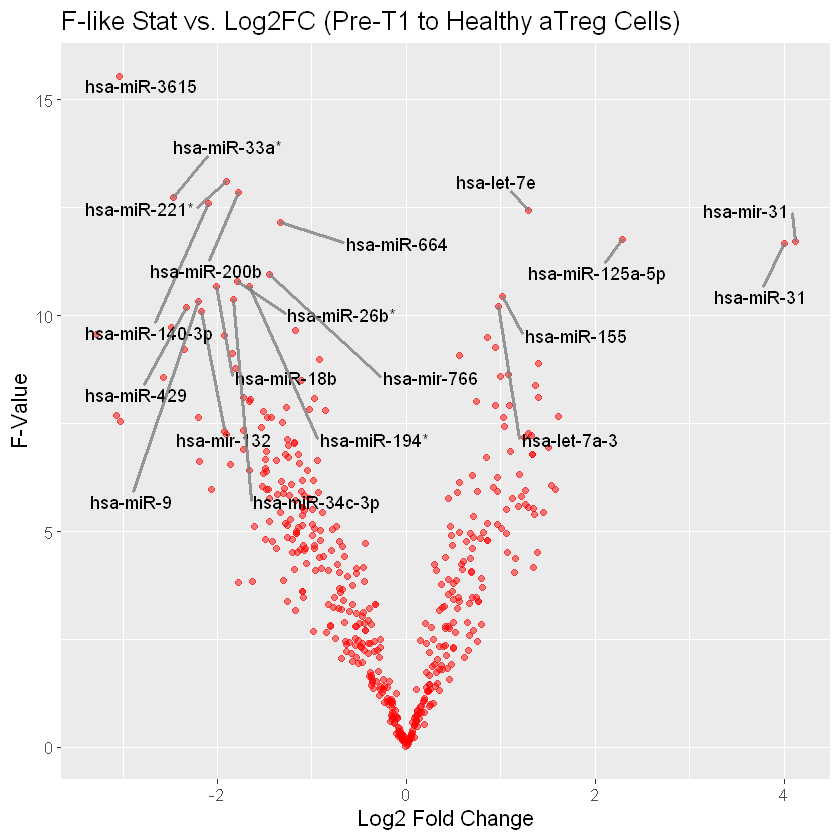

In [443]:
# f contains the fold change, F contains the abs-F value

# f <- x[names(-sort(-F))[1:166],1]-x[names(-sort(-F))[1:166],2]

f <- x[names(-sort(-F))[1:absFOver9.6],1]-x[names(-sort(-F))[1:absFOver9.6],2] # fold change on the mirna with ABS F>9.6

names(f)<-names(-sort(-F))[1:absFOver9.6]
# -sort(-f)

# filter by abs(logFC) >= 1
id<-c(names(f[f>=1]),names(f[-f>=1]))
# length(id)

# calculate logFC again for mirna which meet filters, might be redundant
y<-d[id,]
de<-rownames(x)%in%id
f<-c(x[de,1]-x[de,2])

saved_mirna<- rownames(x[de,])
names(f)<- saved_mirna
sort(f) # gives us the filtered names of mirna with absF > 9.6 with abs(logFC) >=1.

fval<-as.numeric(F)
fold<-as.numeric(x[,1]-x[,2])

volcanodf<-data.frame(fold,fval)


## 20 highest F-values labeled
numToLabel = 20

ggplot(volcanodf, aes(fold,fval)) +
    geom_point(color='red',alpha = 0.5) + 
    geom_text_repel(aes(fold,fval),segment.size = 1, min.segment.length=0.5, box.padding=1,
    segment.alpha = .8,
    force = 1,segment.color = "grey50",label=as.character(ifelse(F >= as.numeric(-sort(-F)[numToLabel]), colnames(F), NA)),hjust=0,vjust=0) +
    labs(y= "F-Value", x = "Log2 Fold Change") +
    ggtitle("F-like Stat vs. Log2FC (Pre-T1 to Healthy aTreg Cells)") + theme(text = element_text(size = 13))   



In [212]:
# text(fold,fval,labels=as.character(ifelse(F >= as.numeric(-sort(-F)[10]), colnames(-sort(-F)), NA)),cex=0.8)
as.numeric(-sort(-F)[10])

[1] 12.5952

In [182]:
# -sort(-F)[1:10]
as.numeric(-sort(-F)[1:10])
colnames(-sort(-F)[1:10])


[1] 16.39912 15.59868 14.68065 14.57055 13.71081 13.23754 13.12501 12.92099
 [9] 12.79181 12.59520

[1] "hsa-mir-101-1"  "hsa-mir-101-2"  "hsa-miR-99b*"   "hsa-miR-455-3p"
 [5] "hsa-miR-126*"   "hsa-miR-155"    "hsa-miR-877"    "hsa-mir-125a"  
 [9] "hsa-mir-130b"   "hsa-miR-375"

In [171]:
f[1:10]

hsa-mir-101-1  hsa-mir-101-2   hsa-miR-99b* hsa-miR-455-3p   hsa-miR-126* 
     -2.811671      -3.592375      -3.023655      -2.547671      -2.502306 
   hsa-miR-155    hsa-miR-877   hsa-mir-125a   hsa-mir-130b    hsa-miR-375 
     -2.008022      -2.984401      -2.873113      -2.416035      -2.064831

In [109]:
names(-sort(-F))[1:7]

[1] "hsa-mir-101-1"  "hsa-mir-101-2"  "hsa-miR-99b*"   "hsa-miR-455-3p"
[5] "hsa-miR-126*"   "hsa-miR-155"    "hsa-miR-877"

In [94]:
# nf<-calcNormFactors(d$counts)
# design<-model.matrix(~group)
# design

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
GSM1088200_M7_Naive,pret1Naive,13099.5,1
GSM1088201_M8_Naive,pret1Naive,6113.5,1
GSM1088202_M9_Naive,pret1Naive,70768.5,1
GSM1088203_M10_Naive,pret1Naive,56314.5,1
GSM1088204_M12_Naive,pret1Naive,230895.5,1
GSM1088205_M29_Naive,pret1Naive,8918223.5,1
GSM1088238_P1_Naive,healthyNaive,87573.5,1
GSM1088239_P2_Naive,healthyNaive,4475767.5,1
GSM1088240_P3_Naive,healthyNaive,252691.5,1


,GSM1088200_M7_Naive,GSM1088201_M8_Naive,GSM1088202_M9_Naive,GSM1088203_M10_Naive,GSM1088204_M12_Naive,GSM1088205_M29_Naive,GSM1088238_P1_Naive,GSM1088239_P2_Naive,GSM1088240_P3_Naive,GSM1088241_P4_Naive,GSM1088242_P5_Naive,GSM1088243_P6_Naive,GSM1088244_P7_Naive
hsa-let-7a,15.623942,14.715729,15.935955,15.350942,15.738855,16.7248453,14.634572,15.509935,16.091482,15.9434825,16.1625003,16.4338494,16.0940829
hsa-let-7a-1,10.982265,8.675714,9.854172,10.857709,10.496231,10.1990765,8.817143,8.029541,10.612085,10.6280698,10.9165616,10.3967171,10.5466639
hsa-let-7a-2,11.035704,10.054225,10.169477,9.626083,10.738570,10.2595794,9.083217,8.158101,10.774085,10.8948392,11.0276267,10.6063610,10.7705953
hsa-let-7a-3,10.808933,8.675714,9.809434,9.340174,10.447843,10.1787038,8.853212,7.944428,10.517881,10.5438207,10.8805213,10.3421066,10.4782007
hsa-let-7a*,5.254344,6.353786,2.820749,3.150350,4.284613,4.3549963,2.513362,5.349618,2.569513,0.5339921,5.5093366,1.9830892,3.0258397
hsa-let-7b,14.140041,14.912206,14.178851,12.158778,14.279438,14.8377324,12.218994,13.777387,13.873865,13.4992353,13.9611839,14.5753126,13.5659226
hsa-let-7b*,5.254344,6.353786,2.820749,3.150350,4.284613,0.3668056,4.098324,1.882259,3.306479,3.3413470,1.0975230,1.9830892,0.4069298
hsa-let-7c,10.611896,9.813217,11.208766,10.444970,9.825494,10.1553466,9.307778,9.937048,10.441932,10.3365085,10.3308003,11.1097936,9.9424830
hsa-let-7d,11.697288,12.135145,12.626493,13.006775,12.872495,13.0179256,11.317493,12.004460,13.034059,12.5977242,12.8760109,13.1013814,13.4379171
hsa-let-7d*,5.254344,6.353786,6.280180,4.735312,6.324141,3.1378644,6.213802,5.208552,5.232478,5.0575541,3.7164329,3.5680517,4.1073696


Warning message in t(log2(t(counts + 0.5)/(lib.size + 1) * 1e+06)):
"NaNs produced"


       (Intercept) grouppret1Naive
Down             0               0
NotSig           0             627
Up             627               0

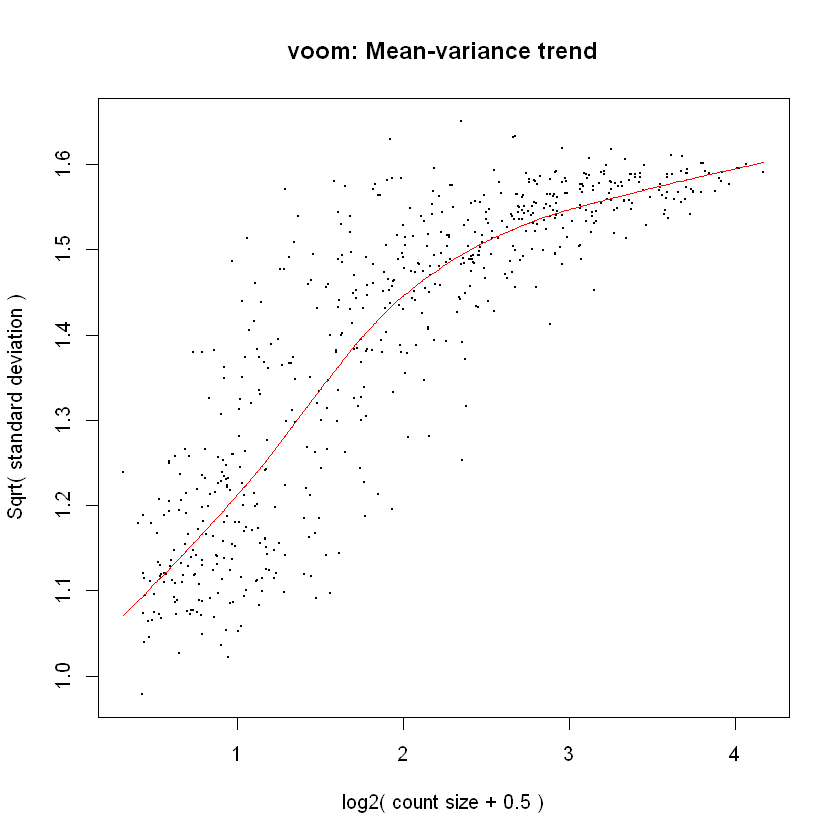

In [80]:
# y<-voom(d$counts,plot=TRUE,design,lib.size=colSums(d$counts)*nf)
y<-voom(d,plot=TRUE,design,lib.size=colSums(d)*nf)

fit <- lmFit(y,design)
fit <- eBayes(fit)
summary(decideTests(fit))
degene<-topTable(fit,coef=2,n=5)

In [85]:
topTable(fit,coef=2, sort.by='P',number=30)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hsa-mir-590,-2.850307,9.867564,-3.092636,0.004057663,0.6421772,-4.564457
hsa-mir-95,-2.692127,9.623154,-2.874875,0.007187460,0.6421772,-4.569343
hsa-miR-548z,-2.767276,9.680486,-2.762023,0.009642810,0.6421772,-4.574484
hsa-mir-15b,-2.495379,9.938220,-2.699533,0.010933962,0.6421772,-4.571652
hsa-miR-491-5p,-2.362071,9.628882,-2.616755,0.013366618,0.6421772,-4.570522
hsa-mir-424,-2.465130,9.876387,-2.550375,0.015836177,0.6421772,-4.576523
hsa-miR-181c*,-2.560758,9.335744,-2.503300,0.017882237,0.6421772,-4.576227
hsa-miR-330-5p,-2.256747,9.846006,-2.483886,0.018336644,0.6421772,-4.574728
hsa-miR-3940-3p,-2.390570,9.423938,-2.480747,0.018846088,0.6421772,-4.577526


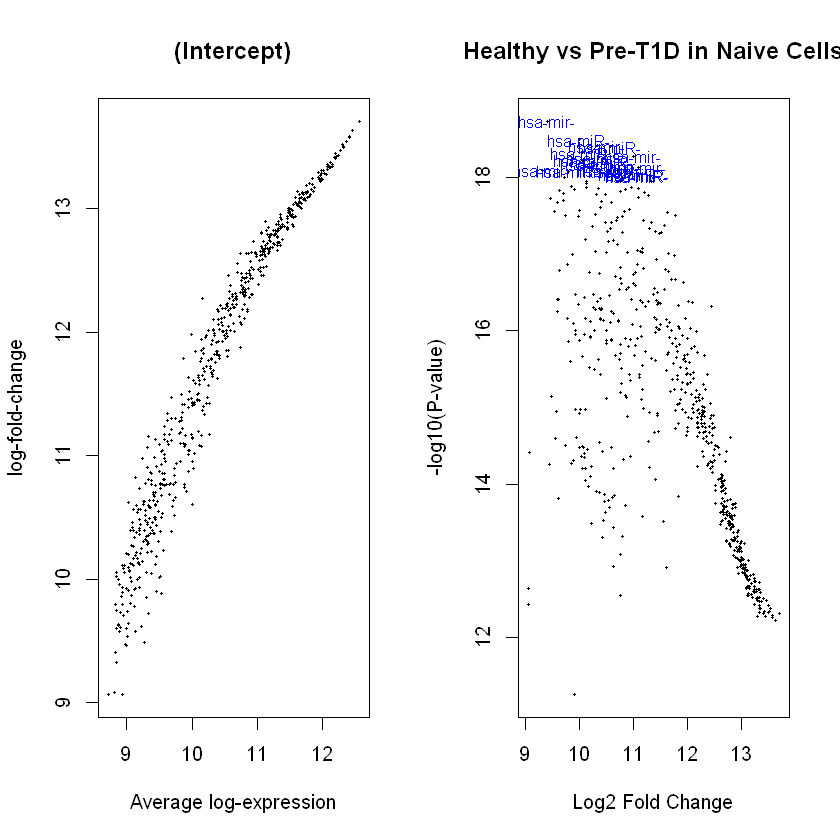

In [87]:
par(mfrow=c(1,2))
plotMD(fit,coef=1, values = c(-1, 1))

# For the volcano plot we have to specify how many of the top genes to highlight.
# We can also specify that we want to plot the gene symbol for the highlighted genes.
# let's highlight the top 100 most DE genes
volcanoplot(fit,coef=1,highlight=20,names=rownames(fit))
title('Healthy vs Pre-T1D in Naive Cells')

In [18]:
# topTable(fit,coef=2,sort.by="p", n = "Inf")


In [19]:
# selects only rtreg and atreg
c1<- countdata[8:20]+0.5
group<-factor(c(rep("rTreg",7),rep("aTreg",6)))
d <- DGEList(counts=c1,group=group)
d$samples
dd <- d[rowSums(d$counts) >= 1.5*ncol(d), ]
d<-1e+06 * dd$count/expandAsMatrix(d$samples$lib.size,dim(dd))

d<-log2(d)

F<-data.frame(nrow(d))


x<-data.frame(nrow(d),2)

# ABS F FUNCTION
for (i in 1:nrow(d)) { # for each mirna
    a<-7*abs(mean(d[i,1:7])-mean(d[i,1:13]))+6*abs(mean(d[i,8:13])-mean(d[i,1:13]))
    # mean of the first group - mean of all groups for each mirna, + the difference in means between the second group and all mirna
    # MULTIPLY EACH ABS DIFF BY THE GROUP SIZE.
    bb = 0
    for (j in 1:7) { # FIRST GROUP
        b<-abs(d[i,j]-mean(d[i,1:7]))
        bb = bb +b
        }

    for (j in 8:13) { # SECOND GROUP
        b<-abs(d[i,j]-mean(d[i,8:13]))
        bb = bb +b
    }

    F[i]<-12*a/bb

    x[i,2]<-mean(d[i,1:7])
    x[i,1]<-mean(d[i,8:13])

}

# F is a vector with the absF score for each mirna.
names(F)<-rownames(d)
rownames(x)<-rownames(d)
length(F[F>9.6,])

## 93 for rTreg 2 aTreg
# 109

mydist<-function(c) {
require(amap)
Dist(c,method="pearson")
 }
myclust<-function(c) { hclust(c,method='ward.D') }
heatmap.2(d,distfun=mydist,hclustfun=myclust,trace="none",cexRow=1.0,cexCol=1.2,las=2,col=greenred(30),lhei=c(1,7),scale="row",sepcolor="yellow", sepwidth = 0.1,margin=c(9,9))




ERROR: Error in `[.data.frame`(countdata, 8:20): undefined columns selected


In [ ]:
f<-x[names(-sort(-F))[1:93],1]-x[names(-sort(-F))[1:93],2]
names(f)<-names(-sort(-F))[1:93]
id<-c(names(f[f>=2]),names(f[-f>=2]))

In [ ]:
d

In [ ]:
# When in doubt, a threshold of 1 CPM in at least the minimum group's sample size is a good rule of thumb.

In [ ]:
# print(required_columns)
# countdata <- cast(all, miRNA ~ sampleName, value= 'Total.miRNA.reads', fill= 0)
# countdata

In [ ]:
# myCPM <- cpm(countdata)
myCPM <- countdata
head(myCPM)

In [20]:
# Which values in myCPM are greater than 0.5?
thresh <- myCPM > 1
# This produces a logical matrix with TRUEs and FALSEs
head(thresh)

ERROR: Error in eval(expr, envir, enclos): object 'myCPM' not found


In [21]:
table(rowSums(thresh))

ERROR: Error in is.data.frame(x): object 'thresh' not found


In [22]:
# we would like to keep genes that have at least 5 TRUES in each row of thresh
keep <- rowSums(thresh) >= 7
# Subset the rows of countdata to keep the more highly expressed genes
counts.keep <- countdata[keep,]
summary(keep)

ERROR: Error in is.data.frame(x): object 'thresh' not found


In [23]:
dim(counts.keep)


ERROR: Error in eval(expr, envir, enclos): object 'counts.keep' not found


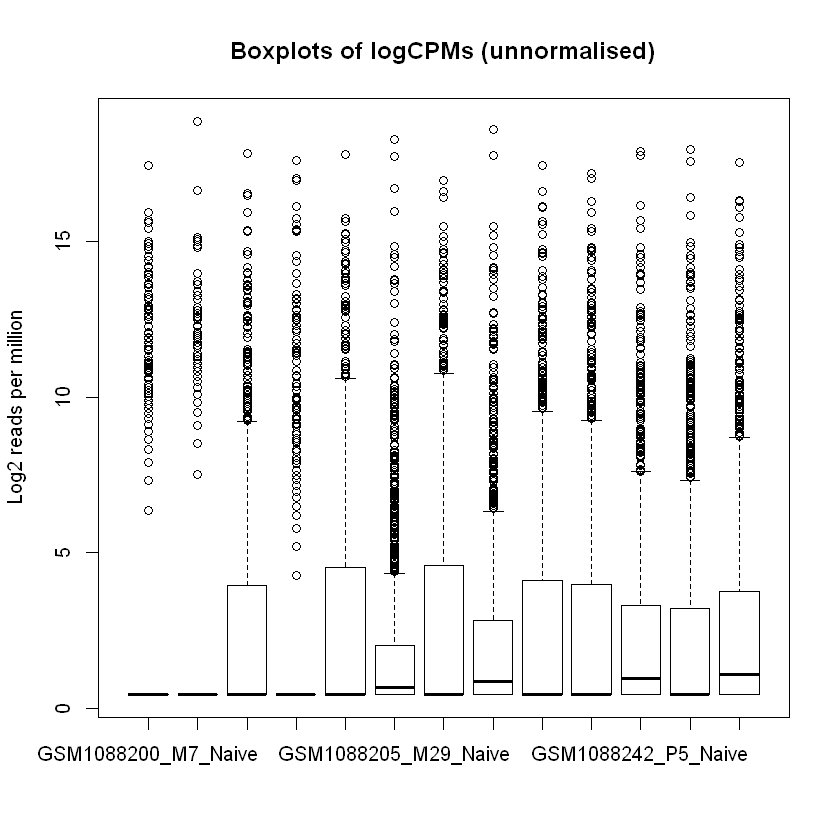

In [24]:
# rownames(counts.keep) <- counts.keep$miRNA
# counts.keep$miRNA <- NULL
# counts.keep

# Get log2 counts per million
logcounts <- cpm(countdata, log=TRUE)
# Check distributions of samples using boxplots
boxplot(logcounts, xlab="", ylab="Log2 reads per million")
# Let's add a blue horizontal line that corresponds to the median logCPM
# abline(h=median(logcounts),col="blue")
title("Boxplots of logCPMs (unnormalised)")


In [25]:

y2 <- DGEList(countdata)
# Apply normalisation to DGEList object
y2 <- calcNormFactors(y2)
y2

,GSM1088200_M7_Naive,GSM1088201_M8_Naive,GSM1088202_M9_Naive,GSM1088203_M10_Naive,GSM1088204_M12_Naive,GSM1088205_M29_Naive,GSM1088238_P1_Naive,GSM1088239_P2_Naive,GSM1088240_P3_Naive,GSM1088241_P4_Naive,GSM1088242_P5_Naive,GSM1088243_P6_Naive,GSM1088244_P7_Naive
hsa-let-7a,661,164,4436,2353,12626,965958,2227,208844,17644,21761,119971,33589,184659
hsa-let-7a-1,26,2,65,104,333,10483,39,1169,395,546,3161,511,3948
hsa-let-7a-2,27,6,81,44,394,10932,47,1278,442,657,3414,591,4611
hsa-let-7a-3,23,2,63,36,322,10336,40,1102,370,515,3083,492,3765
hsa-let-7a*,0,0,0,0,4,182,0,182,1,0,74,1,21
hsa-let-7b,236,188,1312,257,4591,261144,417,62845,3793,3998,26086,9262,32012
hsa-let-7b*,0,0,0,0,4,11,1,16,2,3,3,1,3
hsa-let-7c,20,5,167,78,209,10170,55,4387,351,446,2106,838,2597
hsa-let-7d,43,27,447,463,1731,73971,223,18389,2119,2140,12295,3334,29294
hsa-let-7d*,0,0,5,1,18,78,6,165,9,11,21,4,45


In [26]:
y <- DGEList(counts.keep)
# Apply normalisation to DGEList object
y <- calcNormFactors(y)
y

ERROR: Error in is.data.frame(counts): object 'counts.keep' not found


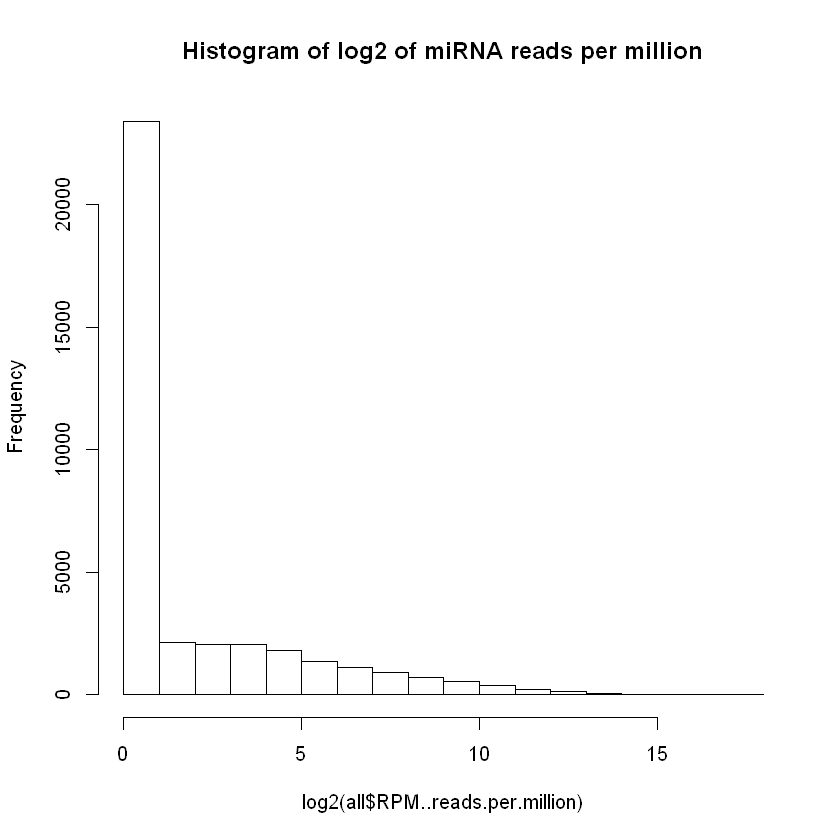

In [27]:
hist(log2(all$RPM..reads.per.million), main='Histogram of log2 of miRNA reads per million')

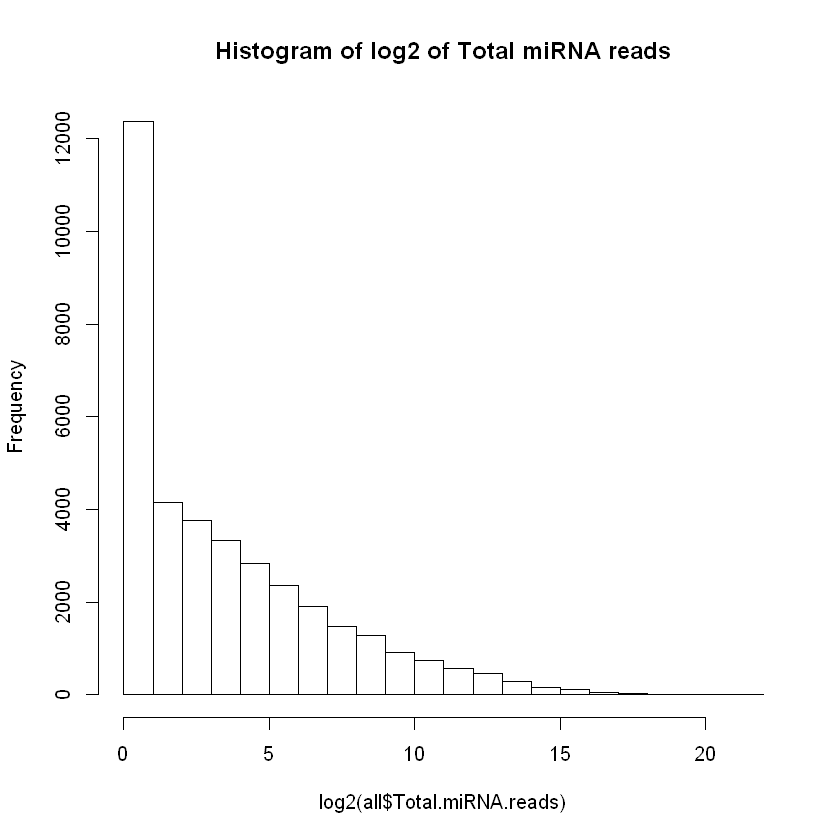

In [28]:
hist(log2(all$"Total.miRNA.reads"), main='Histogram of log2 of Total miRNA reads')


In [29]:
counts.keep

ERROR: Error in eval(expr, envir, enclos): object 'counts.keep' not found


In [30]:
sampleinfo <- all[row.names(unique(all[,c("sampleName", "cellType", "healthy")])),][,c("sampleName", "healthy", "cellType")]
row.names(sampleinfo) <- NULL

data.frame(sampleinfo$CellType)
head(sampleinfo)

<0 x 0 matrix>

,sampleName,healthy,cellType
,<chr>,<lgl>,<chr>
1,GSM1088200_M7_Naive,TRUE,Naive
2,GSM1088201_M8_Naive,TRUE,Naive
3,GSM1088202_M9_Naive,TRUE,Naive
4,GSM1088203_M10_Naive,TRUE,Naive
5,GSM1088204_M12_Naive,TRUE,Naive
6,GSM1088205_M29_Naive,TRUE,Naive


In [31]:
labels <- paste(sampleinfo$sampleName, sampleinfo$cellType, sampleinfo$healthy)
group <- paste(sampleinfo$healthy,sep=".")
group <- factor(group)
glMDSPlot(y, labels=labels, groups=group, folder="mds")

ERROR: Error in data.frame(points, label = labels, groups): arguments imply differing number of rows: 13, 79


In [32]:
# our groups
group

[1] TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE 
[13] TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE 
[25] TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE 
[37] TRUE  TRUE  FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE
Levels: FALSE TRUE

In [33]:
# Specify a design matrix without an intercept term
design <- model.matrix(~ 0 + group)

In [34]:
colnames(design) <- levels(group)

In [35]:
par(mfrow=c(1,1))
v <- voom(y,design,plot = TRUE)

Warning message in t(log2(t(counts + 0.5)/(lib.size + 1) * 1e+06)):
"NaNs produced"


ERROR: Error in lmFit(y, design, block = block, correlation = correlation, weights = weights): row dimension of design doesn't match column dimension of data object


In [36]:
par(mfrow=c(1,2))
boxplot(logcounts, xlab="", ylab="Log2 counts per million",las=2,main="Unnormalised logCPM")
## Let's add a blue horizontal line that corresponds to the median logCPM
abline(h=median(logcounts),col="blue")
boxplot(v$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
## Let's add a blue horizontal line that corresponds to the median logCPM
abline(h=median(v$E),col="blue")

ERROR: Error in boxplot(v$E, xlab = "", ylab = "Log2 counts per million", las = 2, : object 'v' not found


In [37]:
names(v)

ERROR: Error in eval(expr, envir, enclos): object 'v' not found


In [38]:
fit <- lmFit(v)
names(fit)

ERROR: Error in is(object, "list"): object 'v' not found


In [39]:
# we want to compare healthy naive cells to pre-t1 naive cells
cont.matrix <- makeContrasts(B.healthVsdiab=Naive.TRUE - Naive.FALSE,levels=design)
cont.matrix

ERROR: Error in makeContrasts(B.healthVsdiab = Naive.TRUE - Naive.FALSE, levels = design): The levels must by syntactically valid names in R, see help(make.names).  Non-valid names: FALSE,TRUE


In [ ]:
fit.cont <- contrasts.fit(fit, cont.matrix)
fit.cont <- eBayes(fit.cont)
dim(fit.cont)


In [ ]:
summa.fit <- decideTests(fit.cont)
summary(summa.fit)

In [ ]:
topTable(fit.cont,coef="B.healthVsdiab",sort.by="logFC", number=30)


In [ ]:
par(mfrow=c(1,2))
plotMD(fit.cont,coef=1,status=summa.fit[,"B.healthVsdiab"], values = c(-1, 1))

# For the volcano plot we have to specify how many of the top genes to highlight.
# We can also specify that we want to plot the gene symbol for the highlighted genes.
# let's highlight the top 100 most DE genes
volcanoplot(fit.cont,coef=1,highlight=100,names=fit.cont$genes$SYMBOL)

In [ ]:
fit.cont